# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 



## Homework 6: Multilayer Feedforward Network - Dealing with Missing Data


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Names of person you have worked with goes here:**
<br><BR>

In [128]:
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display



In [641]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['b', 'r', 'm'])

<div class="theme"> Overview </div>

In this homework, you are free to explore different ways of solving the problems -within the restrictions of the questions. Your solutions should read like a report with figures to support your statements. Please include your code cells as usual but augment your solutions with written answers. We will also check for code readability and efficiency as we feel you have some experience now. In particular, for Q1, we expect you to write appropriate functions, such as your code can be generalized beyond the specified network architectures of his homework.

For this homework you may **not** use a machine learning library such as `keras` or `tensorflow` to build and fit the network. The objective is to build the network equations from scratch.

- Q1 explores approximating a function using a **Multilayer Feedforward Network** with one input layer, one hidden layer, and one output layer. 

- Q2 deals with missing data in a medical dataset.

<div class="exercise"> <b> Question 1: Construct a feed forward neural network [50 pts]</b> </div>
    
In this part of the homework you are to construct three feed forward neural networks consisting of an input layer, one hidden layer with 1, 2 and 4 nodes respectively, and an output layer.  The hidden layer uses the sigmoid as the activation function and use a linear  output node. 
You should code the equations from scratch. 

You are given three datasets containing ($x,y$) points where $y=f(x)$:

- In the first dataset, $f(x)$ is a **single step** function (data in`data/step_df.csv`), 
- In the second dataset, $f(x)$ is a **one hump** function (data in `data/one_hump_df.csv`),
- In the third dataset, $f(x)$ is a **two equal humps** function (data in `data/two_hump_df.csv`).

**1.1** Create a plot of each dataset and explore the structure of the data. 

**1.2**  Give values to the weights **manually**, perform a forward pass using the data for the **single step** function and a hidden layer of **one** node, and plot the output from the network, in the same plot as the true $y$ values. Adjust the weigths (again manualy) until the plots match as closely as possible.

**1.3** Do the same for the **one hump** function data, this time using a hidden layer consisting of **two** nodes.

**1.4** Do the same for the **two hump** function data but this time increase the number of hidden nodes to **four**.  

**1.5** Choose the appropriate loss function and calculate and report the loss from all three cases. Derive the gradient of the output layer's weights for all three cases (step, one hump and two humps). Use the weights for the hidden layers you found in the previous question and perform gradient descent on the weights of this layer (output layer). What is the optimised weight value and loss you obtained? How many steps did you take to reach this value? What is the threshold value you used to stop? 

### Answers

**1.1** 

In [3]:
# read in data sets as dataframes
step_df = pd.read_csv("data/step_df.csv")
one_hump_df = pd.read_csv("data/one_hump_df.csv")
two_hump_df = pd.read_csv("data/two_hump_df.csv")

In [141]:
# plot the raw x,y data from data frame
def plot_df_xy(df, ax=None):
    
    # define default axes
    if ax is None:
        ax = plt.gca()
        
    # get permutation for sorted values of x
    x_permutation = np.argsort(df.x.values)
    
    # plot line in sequential increasing values of x
    ax.plot(df.x.values[x_permutation], df.y.values[x_permutation], label='raw data', lw=3)
    plt.xlabel("X")
    plt.ylabel("Y")
    return((ax,x_permutation))

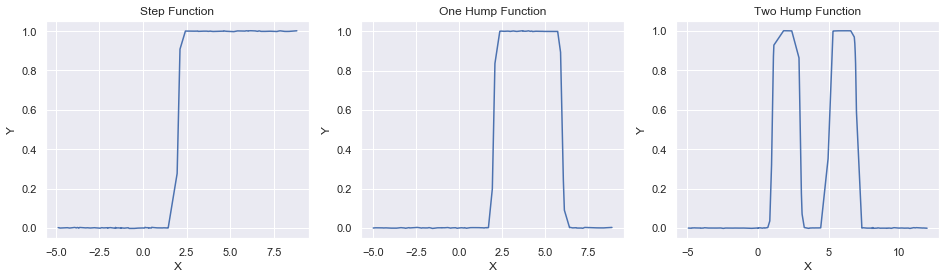

In [132]:
# visualize raw data for all 3 dataframes
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_df_xy(step_df)
plt.title("Step Function")

plt.subplot(1,3,2)
plot_df_xy(one_hump_df)
plt.title("One Hump Function")

plt.subplot(1,3,3)
plot_df_xy(two_hump_df)
plt.title("Two Hump Function");

**1.2** Give values to the weights manually, perform a forward pass using the data for the single step function and a hidden layer of one node, and plot the output from the network, in the same plot as the true  yy  values. Adjust the weigths (again manualy) until the plots match as closely as possible. 

We can start by defining functions for our linear and sigmoid functions.

In [630]:
# calculate z: the linear combination of the input data with the
# mode weights and biases
def z_fun(x: np.ndarray, w, b): 
    """ 
    Compute z: the linear combination of the input data with the
    mode weights and biases
      Inputs:
         x: (m x n) vector of layer input data
         w: (n x p) vector of weights in the current layer
         b: (1 x p) vector of biases in the current layer
      Outputs:
         z: (num_observations x num_nodes) array of outputs from current layer
     """
    
    # ensure arrays are correct shape for matrix multiplication
    x = x.reshape(x.shape[0],-1)
    x = np.concatenate((x,np.ones((x.shape[0],1))),axis=1)
    if type(b) is np.ndarray and any(b.shape):
        params = np.concatenate((w,b), axis=0)
    else:
        params = np.append(w,b)
        
    params = params.reshape(params.shape[0],-1)
    z = np.matmul(x,params)
    return(z)

In [445]:
# define sigmoid function
def sig_fun(z): 
    """ 
    Compute sigmoid:
      Inputs:
         z: ndarray of values
      Outputs:
         h: ndarray of shape(z) containing sigmoid(z)
     """
    return(1/(1+np.exp(-z*z)))

There is no need to define a separate linear output function, as we can just repurpose `z_fun` above for the output as well. Now we can define a single function to to run a single iteration of the network.

In [446]:
def hidden_layer_network(x, hid_w, hid_b, out_w, out_b):    
    """ 
    Compute y: the output of single hidden layer network with
        Inputs:
            x: (num_observations x 1) vector of raw data where N is num observations
            hid_w: (1 x num_hidden) vector of weights in the network hidden layer
            hid_b: (1 x num_hidden) vector of biases in the network hidden layer
            hid_w: (1 x num_output) vector of weights in the network output layer
            hid_b: (1 x num_output) vector of biases in the network output layer
        Outputs:
            out_h: (num_observations x num_output) array of outputs from network output layer
    """
    
    # input the values to layer one linear function and then activate sigmoid
    z = z_fun(x, hid_w, hid_b)
    h = sig_fun(z)

    # pass hidden layer output to the output layer
    out_h = z_fun(h, out_w, out_b)
    return(out_h)
    

To evaluate the models performance, we should define a function to compare the models response var to the true response.

In [275]:
# plot the input data frame and compare to the model output
def plot_model_comparison(df, model_output, label="network output"):
    
    ax, perm = plot_df_xy(df)
    ax.plot(df.x.values[perm], model_output[perm], label=label, lw=3)
    ax.legend()

Let's test out the model by initializing some parameters, running the input through the network and plotting the results

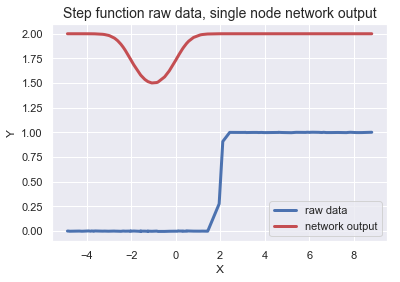

In [582]:
# well start with boths weights=1 and both biases=0
x = step_df.x.values
hidden_w = 1
hidden_b = 1
output_w = 1
output_b = 1

output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)

# plot the output
plot_model_comparison(step_df, output)
plt.title("Step function raw data, single node network output", fontsize=14);

The output looks like and upside down gaussian. Let's try adjusting each of our model weights/biases independently by nudging the parameters up and down to visualize the effects of each parameter on the output.

C:\Users\winsl0w\Anaconda3\lib\site-packages\matplotlib\legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


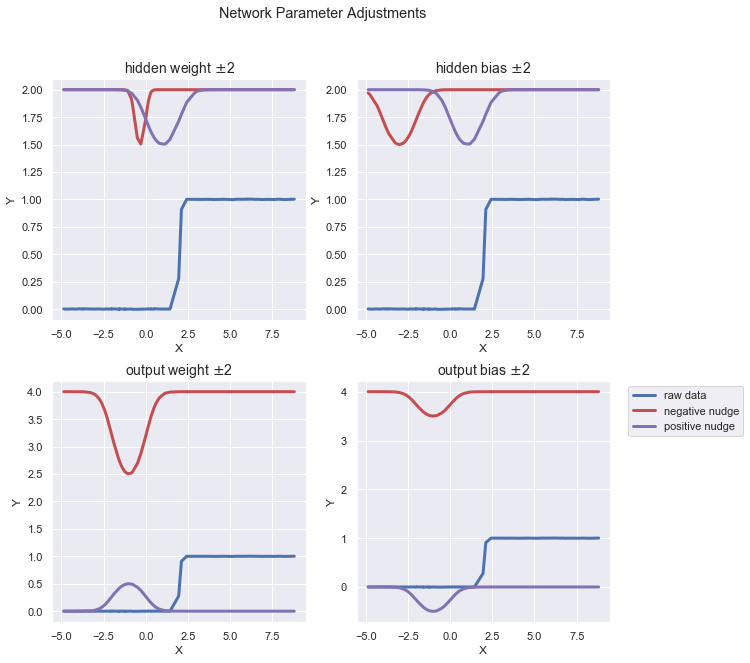

In [585]:
# define parameters and amount to shift each parameter by
params = np.array([hidden_w, hidden_b, output_w, output_b])
p_names = ["hidden weight","hidden bias","output weight","output bias"]
shift = 2

# interate over parameters, shift, and plot results
plt.figure(figsize=(10,10))
for i in range(params.shape[0]):
    
    # plot raw data
    plt.subplot(2,2,i+1)
    ax, perm = plot_df_xy(step_df)
    
    # shift parameter up and plot output
    tmp_p =params.copy()
    tmp_p[i] += shift
    output = hidden_layer_network(x, *tmp_p)
    ax.plot(x[perm], output[perm], lw=3)
    
    # shift parameter down and plot output
    tmp_p[i] += shift*-2
    output = hidden_layer_network(x, *tmp_p)
    ax.plot(x[perm], output[perm], lw=3)
    plt.title("{} $\pm${}".format(p_names[i],shift), fontsize=14);

plt.legend(plt.gca(), labels=["raw data","negative nudge","positive nudge"], bbox_to_anchor=(1.05,1))
plt.suptitle("Network Parameter Adjustments")
plt.subplots_adjust(hspace=.25)

The effects of each parameter on the output might be summarized as follows:

- Hidden Weight - width and horizontal position of the gaussian
- Hidden Bias - horizontal offset of the gaussian
- Output Weight - amplitude and vertical position of the gaussian
- Output Bias - vertical position offset of the gaussian

Therefore, to align the output more closely, we should shift the amplitude positive and shift it to the right. We can start by flipping the curve and adjusting the height with the output weight and shifting the vertical position with the bias.

    

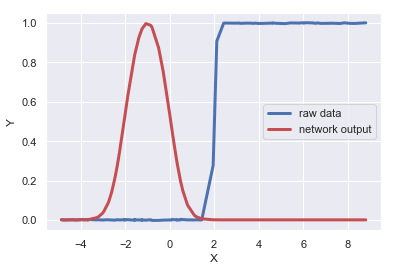

In [334]:
output = hidden_layer_network(x, hidden_w, hidden_b, output_w-3,output_b+1)
ax, perm = plot_df_xy(step_df)
ax.plot(x[perm], output[perm], lw=3,label="network output")
ax.legend();

Now we can shift the horizontal position of the curve and the width by adjusting the hidden layer bias and weight.

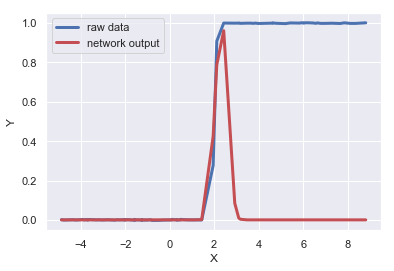

In [335]:
output = hidden_layer_network(x, hidden_w-4, hidden_b+6, output_w-3,output_b+1)
ax, perm = plot_df_xy(step_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend();

This looks close to about as good of a fit as we can expect with the structure of the network as it is now. The raw data resembles a sigmoid function. There is no way to make our output (a gaussian) look like a sigmoid by adjusting the weights and biases. We will likely need to add more nodes or adjust the activation functions to capture the other half of the raw curve.

**1.3** Do the same for the one hump function data, this time using a hidden layer consisting of two nodes.

Since the network function definitions above are capable of accepting additional layers, we do not need to re-define our functions, only the input weights and biases. We can start just by initializing parameters as above.

In [665]:
# define the network input, weights, and biases (for hidden and output layers)
x = one_hump_df.x.values
num_nodes = 2
hidden_w = np.ones((1,num_nodes))
hidden_b = np.zeros((1,num_nodes))
output_w = np.ones((num_nodes,1))
output_b = np.array(0)

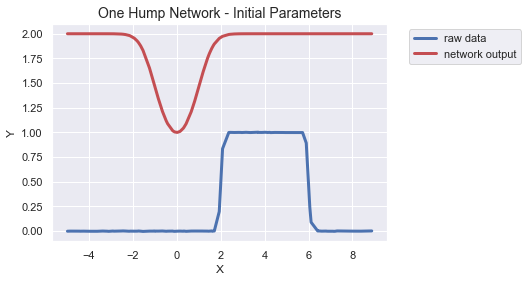

In [603]:
# compute network output and plot results
output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)
ax, perm = plot_df_xy(one_hump_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend(bbox_to_anchor=(1.05,1))
plt.title("One Hump Network - Initial Parameters", fontsize=14);

If we want to match the output, we should flip the output curve about the vertical axis, shift the curve to the right, broaden the width of the curve, and try to make the edges of the hump steeper. We can start investigating the effect of each parameter by shifting the hidden weights.

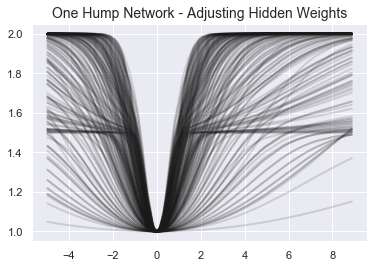

In [712]:
# initialize some values to test
n = 100
w1 = np.concatenate((np.linspace(-2,1,n),np.random.rand(n)*2-1)).reshape(-1,1)
w2 = np.concatenate((np.linspace(-1,2,n),np.random.rand(n)*2-1)).reshape(-1,1)
test_vals = np.concatenate((w1,np.roll(w2,int(np.ceil(n*0.25)))),axis=1)
for i in range(test_vals.shape[0]):
    output = hidden_layer_network(x, test_vals[i,:].reshape(1,2), hidden_b, output_w, output_b)
    plt.plot(x[perm], output[perm], lw=2, color='k', alpha=.15)
    plt.title("One Hump Network - Adjusting Hidden Weights", fontsize=14);

From the plot above, it looks like two gaussians are being added together (which makes sense given the single node model). Tuning the weights of the hidden layer seems to sort of affect the width of the curve. When the two gaussians have very different widths, we see these sharp inflection points in the tails. We can use the same code above to investigate the other parameters.

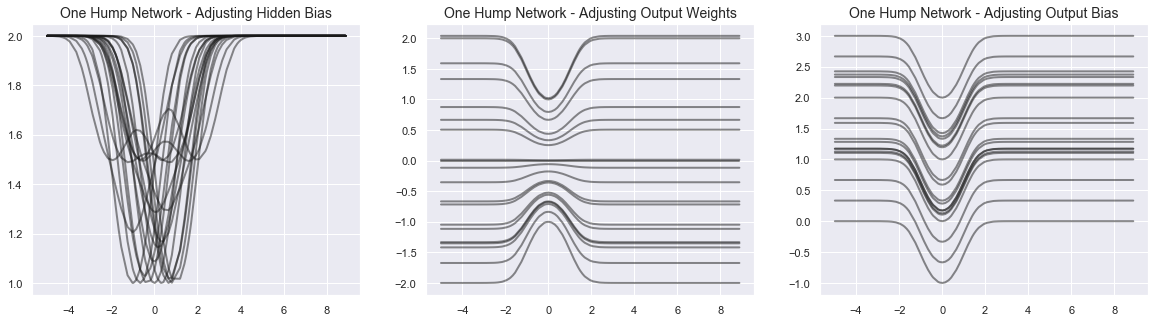

In [713]:
# do the above plot for hidden bias
n = 10
w1 = np.concatenate((np.linspace(-2,1,n),np.random.rand(n)*2-1)).reshape(-1,1)
w2 = np.concatenate((np.linspace(-1,2,n),np.random.rand(n)*2-1)).reshape(-1,1)
test_vals = np.concatenate((w1,np.roll(w2,int(np.ceil(n*0.25)))),axis=1)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
for i in range(test_vals.shape[0]):
    output = hidden_layer_network(x, hidden_w, test_vals[i,:].reshape(1,2), output_w, output_b)
    plt.plot(x[perm], output[perm], lw=2, color='k', alpha=0.5)
    plt.title("One Hump Network - Adjusting Hidden Bias", fontsize=14);
    
# plot for output weight
plt.subplot(1,3,2)
for i in range(test_vals.shape[0]):
    output = hidden_layer_network(x, hidden_w, hidden_b, test_vals[i,:], output_b)
    plt.plot(x[perm], output[perm], lw=2, color='k', alpha=0.5)
    plt.title("One Hump Network - Adjusting Output Weights", fontsize=14);

# plot for output bias
plt.subplot(1,3,3)
for i in range(test_vals.shape[0]):
    output = hidden_layer_network(x, hidden_w, hidden_b, output_w, w1[i].squeeze())
    plt.plot(x[perm], output[perm], lw=2, color='k', alpha=0.5)
    plt.title("One Hump Network - Adjusting Output Bias", fontsize=14);

Based on the above plots, we can summarize the effects of the network:

- Hidden Bias - shifts the two component gaussians horizontally, which causes the relative heights of two humps of the curve to shift since the components are added together
- Output Weights - as before, these weights affect the verticle position and amplitude of the output
- Output Bias - as before the output bias shifts the vertical position of the output

Referencing the strategy above:

We should flip the output curve about the vertical axis (output weights), shift the curve to the right (hidden bias), broaden the width of the curve (spread the two hidden biases apart). For now lets just try adjusting the output weights and hidden biases.

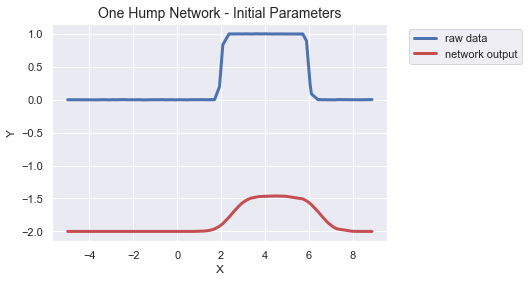

In [720]:
# compute network output and plot results
hidden_b = np.array([-5.5, -3.5]).reshape(1,2)
output_w = np.ones((2,1))*-1

output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)
ax, perm = plot_df_xy(one_hump_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend(bbox_to_anchor=(1.05,1))
plt.title("One Hump Network - Initial Parameters", fontsize=14);

With some tweaking of the parameters we can approach something like the plot below:

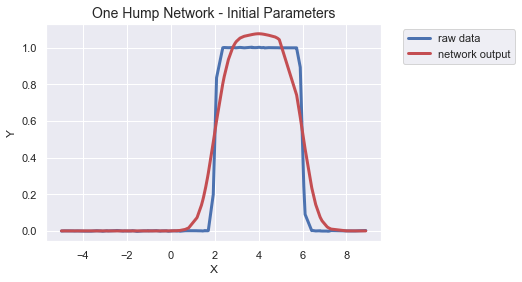

In [761]:
# compute network output and plot results
hidden_w = np.array([-1, -1]).reshape(1,2)
hidden_b = np.array([3, 5]).reshape(1,2)
output_w = np.ones((2,1))*-2
output_b = 4

output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)
ax, perm = plot_df_xy(one_hump_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend(bbox_to_anchor=(1.05,1))
plt.title("One Hump Network - Initial Parameters", fontsize=14);

**1.4** Do the same for the **two hump** function data but this time increase the number of hidden nodes to **four**.  


In [765]:
# define the network input, weights, and biases (for hidden and output layers)
x = two_hump_df.x.values
num_nodes = 4
hidden_w = np.ones((1,num_nodes))
hidden_b = np.zeros((1,num_nodes))
output_w = np.ones((num_nodes,1))
output_b = np.array(0)

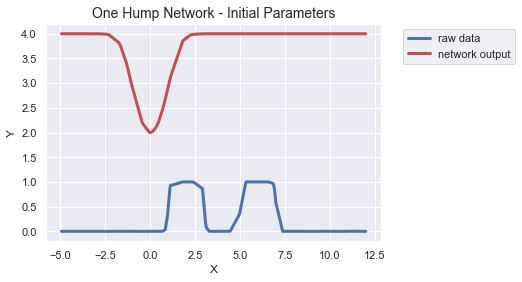

In [766]:
# compute network output and plot results
output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)
ax, perm = plot_df_xy(two_hump_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend(bbox_to_anchor=(1.05,1))
plt.title("Two Hump Network - Initial Parameters", fontsize=14);

Since the two-hump function looks like two copies of the above one-hump example and we have double the nodes in our network, we should be able to repeat the above process for two humps. This time we will be adding 4 curves together. So we can duplicate the process above, just shifting our hidden_biases to adjust the position of the curves.

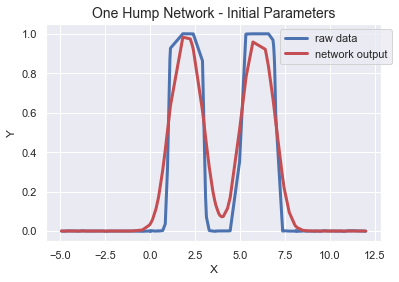

In [787]:
# compute network output and plot results
hidden_w = np.ones(num_nodes).reshape(1,num_nodes)*-1
hidden_b = np.array([2, 2, 6, 6]).reshape(1,num_nodes)
output_w = np.ones((num_nodes,1))*-1
output_b = 4

output = hidden_layer_network(x, hidden_w, hidden_b, output_w, output_b)
ax, perm = plot_df_xy(two_hump_df)
ax.plot(x[perm], output[perm], lw=3, label="network output")
ax.legend(bbox_to_anchor=(1.05,1))
plt.title("One Hump Network - Initial Parameters", fontsize=14);

**1.5** Choose the appropriate loss function and calculate and report the loss from all three cases. Derive the gradient of the output layer's weights for all three cases (step, one hump and two humps). Use the weights for the hidden layers you found in the previous question and perform gradient descent on the weights of this layer (output layer). What is the optimised weight value and loss you obtained? How many steps did you take to reach this value? What is the threshold value you used to stop? 

In [45]:
# your code here


<div class="exercise"> <b> Question 2: Working with missing data. [50 pts]</b> </div>

In this exercise we are going to use the **Pima Indians onset of diabetes** dataset found in `pima-indians-diabetes.csv`. This dataset describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years. It is a binary classification problem (onset of diabetes as 1 or not as 0). The input variables that describe each patient are numerical and have varying scales. The list below shows the eight attributes plus the target variable for the dataset:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skin fold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
-  Body mass index.
-  Diabetes pedigree function.
- Age (years).<br>
- **Outcome** (1 for early onset of diabetes within five years, 0 for not), target class.

**2.1**. Load the dataset into a pandas dataframe named `pima_df`. Clean the data by looking at the various features and making sure that their values make sense. Look for missing data including disguised missing data. The problem of disguised missing data arises when missing data values are not explicitly represented as such, but are coded with values that can be misinterpreted as valid data. Comment on your findings.

**2.2** Split the dataset into a 75-25 train-test split (use `random_state=9001`). Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation (`LogisticRegressionCV`).  Report the overall classification rate.

**2.3** Restart with a fresh copy of the whole dataset and impute the missing data via mean imputation.  Split the data 75-25 (use `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.  

**2.4** Again restart with a fresh copy of the whole dataset and impute the missing data via a model-based imputation method. Once again split the data 75-25 (same `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.

**2.5** Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods,  and explain why you get the results that you see.

**2.6** This question does not have one answer and requires some experimentation. Check which coefficients changed the most between the model in 2.1-2.2 and the models in 2.3 and 2.4. Are they the coefficients you expected to change given the imputation you performed? If not explain why (supporting your explanation using the data is always a good idea).


### Answers

**2.1** 

In [46]:
# your code here


**2.2** 

In [47]:
# your code here


**2.3** 

In [49]:
# your code here


**2.4** 

In [50]:
# your code here


**2.5** 

*your answer here*


**2.6** 